In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t22u9_v2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t22u9_v2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install segment-anything datasets pathlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
# Import libraries
import os
import shutil
import cv2
import numpy as np
import torch
import clip
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from datasets import load_dataset
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import label as scipy_label
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import KMeans
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from transformers import SamModel, SamProcessor
import itertools

In [ ]:
# Load SAM checkpoint
sam_checkpoint_vit_b = "/content/drive/MyDrive/sam_vit_b_01ec64.pth"
sam_checkpoint_vit_h = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"

if os.path.exists(sam_checkpoint_vit_b):
    sam_checkpoint = sam_checkpoint_vit_b
    model_type = "vit_b"
    print("Using SAM vit_b checkpoint.")
elif os.path.exists(sam_checkpoint_vit_h):
    sam_checkpoint = sam_checkpoint_vit_h
    model_type = "vit_h"
    print("Falling back to SAM vit_h checkpoint.")
else:
    raise FileNotFoundError("Neither SAM vit_b nor vit_h checkpoint found. Please download one of the checkpoints manually:\n"
                            "- vit_b: wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P /content/drive/MyDrive/\n"
                            "- vit_h: wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /content/drive/MyDrive/")

Using SAM vit_b checkpoint.


In [11]:
# Define ingredients list (103 classes from FoodSeg103, including background)
ingredients = np.array([
    "background", "candy", "egg tart", "french fries", "chocolate", "biscuit", "popcorn", "pudding",
    "ice cream", "cheese butter", "cake", "wine", "milkshake", "coffee", "juice", "milk", "tea",
    "almond", "red beans", "cashew", "dried cranberries", "soy", "walnut", "peanut", "egg",
    "apple", "date", "apricot", "avocado", "banana", "strawberry", "cherry", "blueberry",
    "raspberry", "mango", "olives", "peach", "lemon", "pear", "fig", "pineapple", "grape",
    "kiwi", "melon", "orange", "watermelon", "steak", "pork", "chicken duck", "sausage",
    "fried meat", "lamb", "sauce", "crab", "fish", "shellfish", "shrimp", "soup", "bread",
    "corn", "hamburg", "pizza", "hanamaki baozi", "wonton dumplings", "pasta", "noodles",
    "rice", "pie", "tofu", "eggplant", "potato", "garlic", "cauliflower", "tomato", "kelp",
    "seaweed", "spring onion", "rape", "ginger", "okra", "lettuce", "pumpkin", "cucumber",
    "white radish", "carrot", "asparagus", "bamboo shoots", "broccoli", "celery stick",
    "cilantro mint", "snow peas", "cabbage", "bean sprouts", "onion", "pepper", "green beans",
    "French beans", "king oyster mushroom", "shiitake", "enoki mushroom", "oyster mushroom",
    "white button mushroom", "salad", "other ingredients"
])

In [ ]:
# --- Confirm Hardware ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Running on device: cuda
PyTorch version: 2.6.0+cu124
CUDA version: 12.4
GPU: NVIDIA L4


# --- Preprocessing Section ---

In [ ]:
# Load dataset
ds = load_dataset("EduardoPacheco/FoodSeg103")
train_dataset = ds["train"]
val_dataset = ds["validation"]

README.md:   0%|          | 0.00/6.71k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [ ]:
# Validate dataset labels before preprocessing
def validate_dataset_labels(dataset, split_name):
    invalid_label_counts = {}
    for entry in tqdm(dataset, desc=f"Validating {split_name} dataset labels"):
        mask = np.array(entry["label"])
        unique_labels = np.unique(mask)
        invalid_labels = unique_labels[(unique_labels < 0) | (unique_labels > 102)]
        if invalid_labels.size > 0:
            entry_id = entry["id"]
            invalid_label_counts[entry_id] = invalid_labels.tolist()

    if invalid_label_counts:
        print(f"Found invalid labels in {split_name} dataset:")
        for entry_id, labels in invalid_label_counts.items():
            print(f"Entry {entry_id}: Invalid labels {labels}")
        print(f"Total entries with invalid labels: {len(invalid_label_counts)}")
    else:
        print(f"No invalid labels found in {split_name} dataset.")
    return invalid_label_counts

In [ ]:
# Run validation on train and validation datasets
train_invalid_label_counts = validate_dataset_labels(train_dataset, "train")
val_invalid_label_counts = validate_dataset_labels(val_dataset, "validation")

Validating train dataset labels: 100%|██████████| 4983/4983 [02:11<00:00, 37.81it/s]


Found invalid labels in train dataset:
Entry 19: Invalid labels [103]
Entry 73: Invalid labels [103]
Entry 137: Invalid labels [103]
Entry 138: Invalid labels [103]
Entry 154: Invalid labels [103]
Entry 156: Invalid labels [103]
Entry 167: Invalid labels [103]
Entry 189: Invalid labels [103]
Entry 325: Invalid labels [103]
Entry 369: Invalid labels [103]
Entry 377: Invalid labels [103]
Entry 384: Invalid labels [103]
Entry 411: Invalid labels [103]
Entry 500: Invalid labels [103]
Entry 513: Invalid labels [103]
Entry 523: Invalid labels [103]
Entry 570: Invalid labels [103]
Entry 574: Invalid labels [103]
Entry 616: Invalid labels [103]
Entry 652: Invalid labels [103]
Entry 720: Invalid labels [103]
Entry 722: Invalid labels [103]
Entry 752: Invalid labels [103]
Entry 792: Invalid labels [103]
Entry 801: Invalid labels [103]
Entry 853: Invalid labels [103]
Entry 868: Invalid labels [103]
Entry 990: Invalid labels [103]
Entry 1034: Invalid labels [103]
Entry 1038: Invalid labels [103]
E

Validating validation dataset labels: 100%|██████████| 2135/2135 [00:16<00:00, 132.56it/s]

Found invalid labels in validation dataset:
Entry 6: Invalid labels [103]
Entry 9: Invalid labels [103]
Entry 43: Invalid labels [103]
Entry 45: Invalid labels [103]
Entry 47: Invalid labels [103]
Entry 55: Invalid labels [103]
Entry 56: Invalid labels [103]
Entry 57: Invalid labels [103]
Entry 116: Invalid labels [103]
Entry 124: Invalid labels [103]
Entry 130: Invalid labels [103]
Entry 134: Invalid labels [103]
Entry 140: Invalid labels [103]
Entry 175: Invalid labels [103]
Entry 209: Invalid labels [103]
Entry 273: Invalid labels [103]
Entry 283: Invalid labels [103]
Entry 301: Invalid labels [103]
Entry 308: Invalid labels [103]
Entry 315: Invalid labels [103]
Entry 346: Invalid labels [103]
Entry 386: Invalid labels [103]
Entry 450: Invalid labels [103]
Entry 513: Invalid labels [103]
Entry 520: Invalid labels [103]
Entry 528: Invalid labels [103]
Entry 545: Invalid labels [103]
Entry 553: Invalid labels [103]
Entry 601: Invalid labels [103]
Entry 629: Invalid labels [103]
Entry 

In [ ]:
def preprocess_image(image, size=(640, 640)):
    image = np.array(image)
    image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    return image

In [ ]:
def preprocess_mask(mask, size=(640, 640), entry_id=None):
    mask = np.array(mask)
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    mask = mask.astype(np.uint8)
    invalid_labels = (mask < 0) | (mask > 102)
    if invalid_labels.any():
        print(f"Entry {entry_id}: Found invalid labels in mask: {np.unique(mask[invalid_labels])}. Mapping to background (0).")
        mask[invalid_labels] = 0
    return mask

In [ ]:
def save_preprocessed_data(dataset, split_name, base_dir="/content/drive/MyDrive/sam_data/foodseg103"):
    split_dir = Path(base_dir) / split_name
    images_dir = split_dir / "images"
    masks_dir = split_dir / "masks"
    images_dir.mkdir(parents=True, exist_ok=True)
    masks_dir.mkdir(parents=True, exist_ok=True)

    for i, entry in enumerate(tqdm(dataset, desc=f"Preprocessing {split_name} data")):
        image = preprocess_image(entry["image"])
        mask = preprocess_mask(entry["label"], entry_id=entry["id"])
        img_path = images_dir / f"{entry['id']}.jpg"
        mask_path = masks_dir / f"{entry['id']}.png"
        cv2.imwrite(str(img_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(mask_path), mask)

In [ ]:
base_dir = "/content/drive/MyDrive/sam_data/foodseg103"
train_dir = Path(base_dir) / "train"
val_dir = Path(base_dir) / "val"

In [ ]:
# Preprocess training data
if train_dir.exists():
    print("Deleting existing training data to re-preprocess...")
    shutil.rmtree(train_dir)
print("Preprocessing training data...")
save_preprocessed_data(train_dataset, "train", base_dir=base_dir)

Deleting existing training data to re-preprocess...
Preprocessing training data...


Preprocessing train data:   1%|          | 26/4983 [00:00<02:28, 33.37it/s]

Entry 19: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   2%|▏         | 80/4983 [00:02<01:40, 48.99it/s]

Entry 73: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   3%|▎         | 142/4983 [00:04<03:18, 24.38it/s]

Entry 137: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 138: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   3%|▎         | 159/4983 [00:05<02:29, 32.23it/s]

Entry 154: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 156: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   3%|▎         | 171/4983 [00:05<02:11, 36.71it/s]

Entry 167: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   4%|▍         | 193/4983 [00:06<02:17, 34.85it/s]

Entry 189: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   7%|▋         | 329/4983 [00:10<02:15, 34.31it/s]

Entry 325: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   8%|▊         | 376/4983 [00:12<03:04, 24.92it/s]

Entry 369: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   8%|▊         | 385/4983 [00:12<02:27, 31.20it/s]

Entry 377: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 384: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:   8%|▊         | 413/4983 [00:13<01:43, 44.35it/s]

Entry 411: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  10%|█         | 505/4983 [00:16<01:44, 42.80it/s]

Entry 500: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  10%|█         | 516/4983 [00:16<01:52, 39.87it/s]

Entry 513: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  11%|█         | 526/4983 [00:16<02:05, 35.61it/s]

Entry 523: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  11%|█▏        | 571/4983 [00:18<02:09, 34.03it/s]

Entry 570: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  12%|█▏        | 581/4983 [00:18<02:17, 31.96it/s]

Entry 574: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  12%|█▏        | 619/4983 [00:19<03:08, 23.17it/s]

Entry 616: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  13%|█▎        | 656/4983 [00:20<02:01, 35.48it/s]

Entry 652: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  15%|█▍        | 727/4983 [00:23<02:39, 26.63it/s]

Entry 720: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 722: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  15%|█▌        | 757/4983 [00:24<02:12, 31.88it/s]

Entry 752: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  16%|█▌        | 799/4983 [00:25<01:37, 42.88it/s]

Entry 792: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 801: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  17%|█▋        | 857/4983 [00:26<01:20, 51.29it/s]

Entry 853: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  17%|█▋        | 868/4983 [00:26<01:50, 37.30it/s]

Entry 868: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  20%|█▉        | 988/4983 [00:30<01:49, 36.37it/s]

Entry 990: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  21%|██        | 1035/4983 [00:31<01:19, 49.61it/s]

Entry 1034: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1038: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  21%|██        | 1055/4983 [00:32<01:57, 33.43it/s]

Entry 1050: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  22%|██▏       | 1086/4983 [00:33<01:37, 40.01it/s]

Entry 1081: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  22%|██▏       | 1096/4983 [00:33<02:29, 26.01it/s]

Entry 1094: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  23%|██▎       | 1123/4983 [00:34<02:01, 31.84it/s]

Entry 1117: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  23%|██▎       | 1131/4983 [00:35<02:01, 31.61it/s]

Entry 1130: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  23%|██▎       | 1156/4983 [00:35<01:37, 39.25it/s]

Entry 1145: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  24%|██▎       | 1175/4983 [00:36<01:11, 53.22it/s]

Entry 1166: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  24%|██▍       | 1212/4983 [00:37<01:37, 38.51it/s]

Entry 1206: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  25%|██▍       | 1230/4983 [00:37<02:14, 27.94it/s]

Entry 1226: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  25%|██▌       | 1267/4983 [00:39<01:31, 40.56it/s]

Entry 1256: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  26%|██▌       | 1283/4983 [00:39<01:43, 35.66it/s]

Entry 1279: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  27%|██▋       | 1334/4983 [00:41<01:38, 37.10it/s]

Entry 1324: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  28%|██▊       | 1384/4983 [00:42<01:35, 37.58it/s]

Entry 1380: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  29%|██▉       | 1444/4983 [00:44<01:27, 40.58it/s]

Entry 1445: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  29%|██▉       | 1461/4983 [00:44<01:30, 38.89it/s]

Entry 1449: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  30%|██▉       | 1482/4983 [00:45<01:40, 34.76it/s]

Entry 1476: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  30%|██▉       | 1493/4983 [00:45<01:23, 41.94it/s]

Entry 1489: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  30%|███       | 1514/4983 [00:46<01:34, 36.85it/s]

Entry 1510: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  30%|███       | 1518/4983 [00:46<02:02, 28.34it/s]

Entry 1517: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  33%|███▎      | 1622/4983 [00:49<01:07, 49.55it/s]

Entry 1616: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1625: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  33%|███▎      | 1650/4983 [00:49<01:28, 37.50it/s]

Entry 1641: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1648: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  33%|███▎      | 1659/4983 [00:50<01:55, 28.66it/s]

Entry 1658: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1660: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  35%|███▍      | 1731/4983 [00:52<01:23, 38.73it/s]

Entry 1726: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  35%|███▌      | 1762/4983 [00:53<01:56, 27.56it/s]

Entry 1761: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  36%|███▌      | 1770/4983 [00:54<02:16, 23.46it/s]

Entry 1771: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  36%|███▋      | 1815/4983 [00:55<01:44, 30.22it/s]

Entry 1811: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  37%|███▋      | 1826/4983 [00:55<01:19, 39.77it/s]

Entry 1818: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  37%|███▋      | 1858/4983 [00:57<01:38, 31.70it/s]

Entry 1853: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  38%|███▊      | 1880/4983 [00:57<01:37, 31.90it/s]

Entry 1878: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  41%|████      | 2034/4983 [01:01<01:31, 32.21it/s]

Entry 2030: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  41%|████      | 2050/4983 [01:02<01:45, 27.77it/s]

Entry 2048: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  42%|████▏     | 2105/4983 [01:03<01:07, 42.43it/s]

Entry 2096: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  43%|████▎     | 2152/4983 [01:05<01:21, 34.67it/s]

Entry 2152: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  44%|████▍     | 2183/4983 [01:06<01:04, 43.44it/s]

Entry 2173: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  45%|████▌     | 2255/4983 [01:08<01:34, 28.93it/s]

Entry 2249: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  46%|████▌     | 2277/4983 [01:09<01:08, 39.78it/s]

Entry 2266: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  46%|████▌     | 2287/4983 [01:09<01:14, 36.04it/s]

Entry 2283: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  47%|████▋     | 2345/4983 [01:11<01:32, 28.42it/s]

Entry 2343: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  47%|████▋     | 2365/4983 [01:12<01:07, 38.63it/s]

Entry 2358: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 2364: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  48%|████▊     | 2414/4983 [01:14<01:33, 27.51it/s]

Entry 2416: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  50%|████▉     | 2468/4983 [01:15<01:05, 38.19it/s]

Entry 2461: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  50%|████▉     | 2491/4983 [01:16<01:23, 29.76it/s]

Entry 2490: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  51%|█████     | 2529/4983 [01:18<00:58, 42.13it/s]

Entry 2518: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  51%|█████▏    | 2554/4983 [01:18<01:11, 34.03it/s]

Entry 2553: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  52%|█████▏    | 2568/4983 [01:19<01:19, 30.34it/s]

Entry 2563: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  52%|█████▏    | 2583/4983 [01:20<01:34, 25.49it/s]

Entry 2579: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  52%|█████▏    | 2593/4983 [01:20<01:11, 33.55it/s]

Entry 2588: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  52%|█████▏    | 2615/4983 [01:21<01:12, 32.53it/s]

Entry 2611: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 2612: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  53%|█████▎    | 2651/4983 [01:22<01:03, 36.51it/s]

Entry 2651: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  54%|█████▍    | 2683/4983 [01:23<01:19, 29.01it/s]

Entry 2675: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  54%|█████▍    | 2694/4983 [01:24<01:05, 35.14it/s]

Entry 2690: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  55%|█████▍    | 2726/4983 [01:24<00:56, 40.26it/s]

Entry 2723: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  56%|█████▌    | 2789/4983 [01:27<01:00, 36.56it/s]

Entry 2783: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  57%|█████▋    | 2859/4983 [01:29<00:55, 38.51it/s]

Entry 2853: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  58%|█████▊    | 2869/4983 [01:29<01:09, 30.47it/s]

Entry 2862: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  59%|█████▉    | 2954/4983 [01:32<00:50, 40.29it/s]

Entry 2948: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 2951: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 2955: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  60%|█████▉    | 2981/4983 [01:32<00:42, 47.09it/s]

Entry 2972: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  60%|██████    | 3004/4983 [01:33<01:01, 32.37it/s]

Entry 3000: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  61%|██████    | 3018/4983 [01:33<01:00, 32.59it/s]

Entry 3011: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  62%|██████▏   | 3095/4983 [01:36<00:56, 33.29it/s]

Entry 3086: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  62%|██████▏   | 3103/4983 [01:36<01:14, 25.34it/s]

Entry 3101: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  64%|██████▍   | 3207/4983 [01:39<00:37, 47.22it/s]

Entry 3196: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  64%|██████▍   | 3213/4983 [01:39<00:35, 49.59it/s]

Entry 3210: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  65%|██████▌   | 3253/4983 [01:41<00:44, 38.60it/s]

Entry 3251: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 3253: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  66%|██████▌   | 3279/4983 [01:41<00:47, 35.63it/s]

Entry 3274: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  66%|██████▌   | 3296/4983 [01:42<00:45, 37.47it/s]

Entry 3291: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  66%|██████▋   | 3312/4983 [01:42<00:42, 38.86it/s]

Entry 3305: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  67%|██████▋   | 3333/4983 [01:43<00:40, 40.88it/s]

Entry 3324: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  69%|██████▉   | 3443/4983 [01:47<00:42, 35.91it/s]

Entry 3438: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  70%|██████▉   | 3482/4983 [01:48<00:39, 37.83it/s]

Entry 3473: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 3478: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  71%|███████   | 3519/4983 [01:49<00:40, 36.07it/s]

Entry 3515: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  71%|███████▏  | 3554/4983 [01:50<00:37, 37.90it/s]

Entry 3553: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  72%|███████▏  | 3569/4983 [01:50<00:39, 35.98it/s]

Entry 3565: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  73%|███████▎  | 3614/4983 [01:52<00:38, 35.55it/s]

Entry 3607: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  73%|███████▎  | 3634/4983 [01:52<00:47, 28.65it/s]

Entry 3631: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  73%|███████▎  | 3660/4983 [01:53<00:33, 39.39it/s]

Entry 3654: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  75%|███████▌  | 3741/4983 [01:55<00:33, 36.84it/s]

Entry 3733: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  75%|███████▌  | 3752/4983 [01:55<00:28, 43.37it/s]

Entry 3749: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  76%|███████▋  | 3804/4983 [01:57<00:26, 43.92it/s]

Entry 3797: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  77%|███████▋  | 3845/4983 [01:58<00:29, 38.89it/s]

Entry 3837: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 3838: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  78%|███████▊  | 3902/4983 [02:00<00:29, 36.87it/s]

Entry 3895: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  79%|███████▊  | 3913/4983 [02:00<00:24, 43.23it/s]

Entry 3907: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  79%|███████▉  | 3940/4983 [02:01<00:30, 34.34it/s]

Entry 3933: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  79%|███████▉  | 3955/4983 [02:01<00:26, 39.30it/s]

Entry 3947: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  80%|███████▉  | 3965/4983 [02:01<00:25, 39.60it/s]

Entry 3960: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  80%|███████▉  | 3974/4983 [02:02<00:37, 26.84it/s]

Entry 3971: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  81%|████████▏ | 4061/4983 [02:05<00:28, 32.51it/s]

Entry 4056: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 4057: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 4058: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  82%|████████▏ | 4091/4983 [02:06<00:29, 30.20it/s]

Entry 4089: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  82%|████████▏ | 4107/4983 [02:06<00:23, 36.63it/s]

Entry 4097: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 4103: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  84%|████████▎ | 4172/4983 [02:08<00:22, 35.71it/s]

Entry 4166: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  85%|████████▍ | 4216/4983 [02:10<00:29, 26.20it/s]

Entry 4213: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  85%|████████▍ | 4227/4983 [02:10<00:24, 30.64it/s]

Entry 4227: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  85%|████████▌ | 4256/4983 [02:11<00:26, 27.61it/s]

Entry 4253: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  86%|████████▌ | 4264/4983 [02:11<00:24, 29.69it/s]

Entry 4260: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  86%|████████▌ | 4278/4983 [02:12<00:24, 29.33it/s]

Entry 4274: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  86%|████████▋ | 4300/4983 [02:13<00:22, 29.93it/s]

Entry 4288: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 4298: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  87%|████████▋ | 4322/4983 [02:13<00:14, 44.27it/s]

Entry 4316: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  88%|████████▊ | 4371/4983 [02:15<00:23, 25.54it/s]

Entry 4367: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  90%|█████████ | 4491/4983 [02:19<00:13, 36.14it/s]

Entry 4487: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  90%|█████████ | 4509/4983 [02:19<00:13, 36.04it/s]

Entry 4503: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  91%|█████████▏| 4547/4983 [02:21<00:15, 28.03it/s]

Entry 4542: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  92%|█████████▏| 4592/4983 [02:22<00:10, 37.22it/s]

Entry 4589: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  93%|█████████▎| 4613/4983 [02:25<00:30, 12.21it/s]

Entry 4606: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  93%|█████████▎| 4639/4983 [02:25<00:13, 25.23it/s]

Entry 4636: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  95%|█████████▍| 4717/4983 [02:29<00:07, 33.89it/s]

Entry 4711: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  96%|█████████▌| 4793/4983 [02:31<00:05, 34.39it/s]

Entry 4786: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  97%|█████████▋| 4853/4983 [02:32<00:02, 46.48it/s]

Entry 4845: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  99%|█████████▉| 4933/4983 [02:35<00:01, 37.94it/s]

Entry 4927: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data:  99%|█████████▉| 4944/4983 [02:35<00:00, 40.96it/s]

Entry 4937: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data: 100%|█████████▉| 4971/4983 [02:35<00:00, 39.52it/s]

Entry 4967: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data: 100%|█████████▉| 4976/4983 [02:36<00:00, 34.84it/s]

Entry 4975: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing train data: 100%|██████████| 4983/4983 [02:36<00:00, 31.84it/s]


In [ ]:
# Preprocess validation data
if val_dir.exists():
    print("Deleting existing validation data to re-preprocess...")
    shutil.rmtree(val_dir)
print("Preprocessing validation data...")
save_preprocessed_data(val_dataset, "val", base_dir=base_dir)

Deleting existing validation data to re-preprocess...
Preprocessing validation data...


Preprocessing val data:   0%|          | 7/2135 [00:00<00:30, 69.59it/s]

Entry 6: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 9: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   2%|▏         | 53/2135 [00:00<00:39, 52.61it/s]

Entry 43: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 45: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 47: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   3%|▎         | 66/2135 [00:01<00:35, 58.16it/s]

Entry 55: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 56: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 57: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   6%|▌         | 127/2135 [00:02<00:35, 56.30it/s]

Entry 116: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 124: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   7%|▋         | 140/2135 [00:02<00:57, 34.68it/s]

Entry 130: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 134: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 140: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   9%|▊         | 186/2135 [00:03<00:34, 56.46it/s]

Entry 175: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  10%|▉         | 212/2135 [00:04<00:34, 56.23it/s]

Entry 209: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  13%|█▎        | 281/2135 [00:05<00:39, 47.37it/s]

Entry 273: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 283: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  14%|█▍        | 305/2135 [00:05<00:38, 47.54it/s]

Entry 301: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 308: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  15%|█▌        | 323/2135 [00:06<00:36, 49.69it/s]

Entry 315: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  17%|█▋        | 355/2135 [00:06<00:32, 54.82it/s]

Entry 346: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  19%|█▊        | 397/2135 [00:07<00:32, 54.00it/s]

Entry 386: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  22%|██▏       | 461/2135 [00:08<00:26, 62.37it/s]

Entry 450: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  25%|██▍       | 524/2135 [00:09<00:29, 55.30it/s]

Entry 513: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 520: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  25%|██▌       | 537/2135 [00:10<00:29, 54.91it/s]

Entry 528: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  26%|██▌       | 551/2135 [00:10<00:28, 56.40it/s]

Entry 545: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 553: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  29%|██▊       | 611/2135 [00:11<00:25, 59.36it/s]

Entry 601: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  30%|██▉       | 636/2135 [00:11<00:25, 57.80it/s]

Entry 629: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  38%|███▊      | 816/2135 [00:15<00:28, 47.02it/s]

Entry 808: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 813: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  39%|███▉      | 839/2135 [00:15<00:25, 49.92it/s]

Entry 832: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  40%|███▉      | 851/2135 [00:15<00:26, 49.25it/s]

Entry 844: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  41%|████      | 871/2135 [00:16<00:21, 57.49it/s]

Entry 859: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  42%|████▏     | 891/2135 [00:16<00:21, 58.52it/s]

Entry 883: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  44%|████▎     | 930/2135 [00:17<00:20, 57.55it/s]

Entry 919: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 922: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  44%|████▍     | 943/2135 [00:17<00:20, 56.98it/s]

Entry 933: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  45%|████▌     | 962/2135 [00:17<00:20, 57.11it/s]

Entry 953: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 960: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  46%|████▌     | 974/2135 [00:18<00:21, 54.99it/s]

Entry 964: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  48%|████▊     | 1026/2135 [00:19<00:20, 55.33it/s]

Entry 1015: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  49%|████▉     | 1047/2135 [00:19<00:18, 58.27it/s]

Entry 1042: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1043: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  50%|█████     | 1071/2135 [00:19<00:20, 53.13it/s]

Entry 1062: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1064: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  52%|█████▏    | 1109/2135 [00:20<00:19, 51.83it/s]

Entry 1102: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1105: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  54%|█████▍    | 1158/2135 [00:21<00:18, 53.71it/s]

Entry 1152: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  56%|█████▌    | 1195/2135 [00:22<00:16, 56.18it/s]

Entry 1191: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  58%|█████▊    | 1234/2135 [00:22<00:16, 56.21it/s]

Entry 1227: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  60%|█████▉    | 1273/2135 [00:23<00:15, 54.00it/s]

Entry 1265: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  60%|██████    | 1286/2135 [00:23<00:16, 51.88it/s]

Entry 1279: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  61%|██████    | 1292/2135 [00:24<00:19, 42.43it/s]

Entry 1291: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  64%|██████▍   | 1366/2135 [00:25<00:14, 53.06it/s]

# --- Fine-Tuning Section ---

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# Custom Dataset for CLIP fine-tuning
class FoodSeg103Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.image_paths = sorted(list(self.image_dir.glob("*.jpg")))
        self.mask_paths = sorted(list(self.mask_dir.glob("*.png")))
        assert len(self.image_paths) == len(self.mask_paths), "Mismatch between images and masks"
        print(f"Loaded {len(self.image_paths)} images and masks from {image_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = cv2.imread(str(img_path))
        if image is None or image.size == 0:
            print(f"Failed to load image: {img_path}")
            image = np.zeros((640, 640, 3), dtype=np.uint8)  # Fallback
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), 0)
        if mask is None or mask.size == 0:
            print(f"Failed to load mask: {mask_path}")
            mask = np.zeros((640, 640), dtype=np.uint8)  # Fallback

        # Get unique labels in the mask (excluding background)
        labels = np.unique(mask)
        labels = labels[labels != 0]  # Exclude background
        if len(labels) == 0:
            labels = [len(ingredients) - 1]  # Default to "other ingredients"
        elif (labels < 0).any() or (labels >= len(ingredients)).any():
            print(f"Invalid labels in {mask_path}: {labels}. Using 'other ingredients'.")
            labels = [len(ingredients) - 1]

        # Ensure label is valid
        label = int(labels[0])  # Explicitly cast to int
        if not (0 <= label < len(ingredients)):
            print(f"Invalid label after processing for {mask_path}: {label}. Using 'other ingredients'.")
            label = len(ingredients) - 1

        # Convert image to PIL for CLIP preprocessing
        image_pil = Image.fromarray(image)
        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            image_tensor = clip_preprocess(image_pil)

        # Validate image tensor
        if torch.isnan(image_tensor).any() or torch.isinf(image_tensor).any():
            print(f"Invalid image tensor for {img_path}")
            image_tensor = torch.zeros_like(image_tensor)

        return image_tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes, freeze_backbone=False):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)
        self.freeze_backbone = freeze_backbone
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
        else:
            # Lower learning rate for backbone
            for param in self.model.parameters():
                param.requires_grad = True

    def forward(self, x):
        if self.freeze_backbone:
            with torch.no_grad():
                features = self.model.encode_image(x).float()
        else:
            features = self.model.encode_image(x).float()
        return self.classifier(features)

In [ ]:
def optimizer_to_device(optimizer, device):
    """Move optimizer state to the specified device."""
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

In [ ]:
def fine_tune_clip(model, train_dataset, device, epochs=5, batch_size=1, lr=1e-6, classifier_lr=1e-3, weight_decay=0.01, debug_cpu=False, freeze_backbone=False):
    # Ensure float32 precision
    torch.set_default_dtype(torch.float32)
    model = model.float()

    # Wrap model with classifier
    fine_tuner = CLIPFineTuner(model, num_classes=len(ingredients), freeze_backbone=freeze_backbone)

    # Move model to initial device (GPU or CPU based on debug_cpu)
    initial_device = torch.device("cpu") if debug_cpu else device
    fine_tuner = fine_tuner.to(initial_device)

    # Initialize optimizer after moving model
    if freeze_backbone:
        optimizer = torch.optim.Adam(fine_tuner.classifier.parameters(), lr=classifier_lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.Adam([
            {'params': fine_tuner.model.parameters(), 'lr': lr},
            {'params': fine_tuner.classifier.parameters(), 'lr': classifier_lr}
        ], weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    print("Starting CLIP fine-tuning...")
    for epoch in range(epochs):
        total_loss = 0
        valid_batches = 0
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            # Debug on CPU for first batch if enabled
            current_device = torch.device("cpu") if debug_cpu and batch_idx == 0 else device

            # Move model and optimizer state to current_device
            fine_tuner = fine_tuner.to(current_device)
            optimizer_to_device(optimizer, current_device)

            # Move inputs to current_device
            images = images.to(current_device, dtype=torch.float32)
            labels = labels.to(current_device, dtype=torch.long)

            # Validate inputs
            if images.shape[0] == 0:
                print(f"Batch {batch_idx}: Empty batch")
                continue
            if torch.isnan(images).any() or torch.isinf(images).any():
                print(f"Batch {batch_idx}: Invalid images (nan/inf detected)")
                for i in range(images.shape[0]):
                    img_path = train_dataset.image_paths[batch_idx * batch_size + i]
                    print(f"Problematic image: {img_path}")
                continue
            if (images.abs() > 1e6).any():
                print(f"Batch {batch_idx}: Extreme values in images")
                for i in range(images.shape[0]):
                    img_path = train_dataset.image_paths[batch_idx * batch_size + i]
                    print(f"Problematic image: {img_path}")
                continue
            if (labels < 0).any() or (labels >= len(ingredients)).any():
                print(f"Batch {batch_idx}: Invalid labels: {labels.tolist()}")
                continue

            # Log device and shape information
            print(f"Batch {batch_idx}: Images device: {images.device}, Labels device: {labels.device}, Model device: {next(fine_tuner.parameters()).device}")
            print(f"Batch {batch_idx}: Images shape: {images.shape}, Labels shape: {labels.shape}")

            optimizer.zero_grad(set_to_none=True)
            # Forward pass
            logits = fine_tuner(images)

            # Validate logits
            expected_logits_shape = (images.shape[0], len(ingredients))
            if logits.shape != expected_logits_shape:
                print(f"Batch {batch_idx}: Invalid logits shape: {logits.shape}, expected: {expected_logits_shape}")
                continue
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print(f"Batch {batch_idx}: Invalid logits: {logits}")
                for i in range(images.shape[0]):
                    img_path = train_dataset.image_paths[batch_idx * batch_size + i]
                    print(f"Problematic image: {img_path}")
                continue

            # Compute loss
            try:
                loss = F.cross_entropy(logits, labels)
            except Exception as e:
                print(f"Batch {batch_idx}: Error computing loss: {e}, Labels: {labels.tolist()}, Logits min/max: {logits.min().item()}/{logits.max().item()}")
                for i in range(images.shape[0]):
                    img_path = train_dataset.image_paths[batch_idx * batch_size + i]
                    print(f"Problematic image: {img_path}")
                continue

            # Check for nan loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Batch {batch_idx}: Invalid loss: {loss.item()}, Logits norm: {logits.norm().item()}")
                for i in range(images.shape[0]):
                    img_path = train_dataset.image_paths[batch_idx * batch_size + i]
                    print(f"Problematic image: {img_path}")
                continue

            # Log loss and batch details
            print(f"Batch {batch_idx}: Labels: {labels.tolist()}, Logits shape: {logits.shape}, Loss: {loss.item()}")

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            valid_batches += 1

        avg_loss = total_loss / valid_batches if valid_batches > 0 else float('nan')
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}, Valid Batches: {valid_batches}/{len(train_loader)}")

    fine_tuner.eval()
    fine_tuner = fine_tuner.to(device)
    return fine_tuner

In [ ]:
# Load CLIP model (stick with ViT-B/32 for faster inference; can upgrade to ViT-L/336 if needed)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 44.6MiB/s]


In [ ]:
# Initialize dataset for CLIP
train_dataset = FoodSeg103Dataset(
    image_dir="/content/drive/MyDrive/sam_data/foodseg103/train/images",
    mask_dir="/content/drive/MyDrive/sam_data/foodseg103/train/masks",
    transform=clip_preprocess
)

Loaded 4983 images and masks from /content/drive/MyDrive/sam_data/foodseg103/train/images


In [ ]:
fine_tuner = fine_tune_clip(
    clip_model,
    train_dataset,
    device,
    epochs=5,
    batch_size=1,
    lr=1e-6,
    classifier_lr=1e-3,
    weight_decay=0.01,
    debug_cpu=True,
    freeze_backbone=False
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save fine-tuned CLIP model
clip_checkpoint = "/content/drive/MyDrive/clip_finetuned_foodseg103.pth"
torch.save(clip_model.state_dict(), clip_checkpoint)
print(f"Saved fine-tuned CLIP model to {clip_checkpoint}")

Saved fine-tuned CLIP model to /content/drive/MyDrive/clip_finetuned_foodseg103.pth


In [ ]:
# Dataset class with transforms
class FoodSeg103Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, debug=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.debug = debug
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((1024, 1024)),  # Match SamProcessor output
            transforms.ToTensor()  # Converts PIL Image to tensor (C, H, W), normalizes to [0, 1]
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((1024, 1024), interpolation=transforms.InterpolationMode.NEAREST)
        ])
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.replace('images', 'masks').replace('.jpg', '.png') for p in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image and mask
        image = Image.open(img_path).convert('RGB')
        try:
            mask = Image.open(mask_path)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return None, None  # Skip invalid mask

        # Convert mask to numpy array
        mask_np = np.array(mask, dtype=np.int64)

        # Validate mask shape
        if mask_np.ndim != 2 or mask_np.shape[0] < 2 or mask_np.shape[1] < 2:
            print(f"Invalid mask shape for {mask_path}: {mask_np.shape}")
            return None, None  # Skip invalid mask

        # Convert to uint8 for PIL compatibility
        mask_np = mask_np.astype(np.uint8)  # FoodSeg103 labels are 0–103, fits in uint8
        mask = Image.fromarray(mask_np)  # Convert to PIL for transform

        # Apply transforms
        image = self.transform(image)
        mask = self.mask_transform(mask)

        # Convert mask back to tensor
        mask_np = np.array(mask, dtype=np.int64)  # Restore int64 for labels
        mask = torch.tensor(mask_np, dtype=torch.long)

        # Debug logging
        if self.debug:
            print(f"Dataset[{idx}]: Image path: {img_path}")
            print(f"Dataset[{idx}]: Image type: {type(image)}, Shape: {image.shape}, Dtype: {image.dtype}")
            print(f"Dataset[{idx}]: Mask path: {mask_path}")
            print(f"Dataset[{idx}]: Mask type: {type(mask)}, Shape: {mask.shape}, Dtype: {mask.dtype}")
            print(f"Dataset[{idx}]: Mask min/max: {mask.min().item()}/{mask.max().item()}")

        return image, mask

In [ ]:
class SAMFineTuner(nn.Module):
    def __init__(self, model, freeze_vision_encoder=True, freeze_prompt_encoder=True):
        super(SAMFineTuner, self).__init__()
        self.model = model
        self.freeze_vision_encoder = freeze_vision_encoder
        self.freeze_prompt_encoder = freeze_prompt_encoder
        if freeze_vision_encoder:
            for param in self.model.vision_encoder.parameters():
                param.requires_grad = False
        if freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        # Mask decoder is always trainable
        for param in self.model.mask_decoder.parameters():
            param.requires_grad = True

    def get_dense_pe(self):
        """Compute dense positional embeddings for the image."""
        embed_size = self.model.prompt_encoder.image_embedding_size
        print(f"Embed size: {embed_size}, Type: {type(embed_size)}")  # Debug
        # Ensure embed_size is an integer
        if isinstance(embed_size, (tuple, list)):
            embed_size = embed_size[0]  # Take first element if tuple
        elif isinstance(embed_size, torch.Tensor):
            embed_size = embed_size.item()  # Convert tensor to scalar
        if not isinstance(embed_size, int):
            raise ValueError(f"Expected embed_size to be an integer, got {type(embed_size)}: {embed_size}")

        device = next(self.model.parameters()).device
        grid = torch.stack(
            torch.meshgrid(
                torch.linspace(0, 1, embed_size, device=device),
                torch.linspace(0, 1, embed_size, device=device),
                indexing="ij"
            ),
            dim=-1
        )  # Shape: [embed_size, embed_size, 2]
        grid = grid.reshape(1, embed_size, embed_size, 2)  # Shape: [1, embed_size, embed_size, 2]
        image_pe = self.model.prompt_encoder.shared_embedding(grid)  # Shape: [1, embed_size, embed_size, hidden_size]
        print(f"Image positional embeddings shape: {image_pe.shape}")  # Debug
        return image_pe

    def forward(self, pixel_values, input_boxes):
        # Vision encoder
        if self.freeze_vision_encoder:
            with torch.no_grad():
                image_embeddings = self.model.vision_encoder(pixel_values)
        else:
            image_embeddings = self.model.vision_encoder(pixel_values)
        if hasattr(image_embeddings, 'last_hidden_state'):
            image_embeddings = image_embeddings.last_hidden_state
        print(f"Image embeddings shape: {image_embeddings.shape}")  # Should be [1, 256, 64, 64]

        # Batch processing
        batch_size = pixel_values.shape[0]  # Typically 1 in your case
        sparse_embeddings_list = []
        for i in range(batch_size):
            box = input_boxes[i]  # [num_boxes, 4]
            box = box.reshape(1, -1, 4)  # [1, num_boxes, 4]
            print(f"Batch {i}: Box shape: {box.shape}")
            sparse_emb, dense_emb = self.model.prompt_encoder(
                input_points=None,
                input_labels=None,
                input_boxes=box,
                input_masks=None
            )
            print(f"Batch {i}: sparse_emb shape: {sparse_emb.shape}, dense_emb: {dense_emb}")
            # sparse_emb: [1, num_boxes, 2, 256], dense_emb should be None
            sparse_emb = sparse_emb.mean(dim=2)  # [1, num_boxes, 256]
            sparse_emb = sparse_emb.squeeze(0)  # [num_boxes, 256]
            sparse_embeddings_list.append(sparse_emb)

        # Stack sparse embeddings correctly
        # Since batch_size=1, take the first (and only) element
        sparse_embeddings = sparse_embeddings_list[0].unsqueeze(0)  # [1, num_boxes, 256]
        print(f"Final sparse_embeddings shape: {sparse_embeddings.shape}")
        dense_embeddings = None  # Explicitly None for box prompts
        print(f"Final dense_embeddings: {dense_embeddings}")

        # Positional embeddings
        image_positional_embeddings = self.get_dense_pe()  # [1, 64, 64, 256]
        print(f"Image positional embeddings shape: {image_positional_embeddings.shape}")

        # Mask decoder
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_positional_embeddings=image_positional_embeddings,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )
        print(f"Low res masks shape: {low_res_masks.shape}")
        return low_res_masks, iou_predictions

In [ ]:
# Utility functions
def get_connected_components(mask):
    mask = np.array(mask)
    structure = np.ones((3, 3), dtype=int)
    labeled, ncomponents = scipy_label(mask > 0, structure)
    boxes = []
    binary_masks = []
    for i in range(1, ncomponents + 1):
        component_mask = (labeled == i).astype(np.uint8)
        y, x = np.where(component_mask)
        if len(y) == 0:
            continue
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        boxes.append([x_min, y_min, x_max, y_max])
        binary_masks.append(component_mask)
    return boxes, binary_masks

In [ ]:
def optimizer_to_device(optimizer, device):
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                state[k] = v.to(device)

In [ ]:
def fine_tune_sam(model, train_dataset, device, save_dir, epochs=5, batch_size=1, lr=1e-5, weight_decay=0.01, debug_cpu=True, freeze_vision_encoder=True, freeze_prompt_encoder=True, save_checkpoints=True):
    torch.set_default_dtype(torch.float32)
    model = model.float()
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    fine_tuner = SAMFineTuner(model, freeze_vision_encoder=freeze_vision_encoder, freeze_prompt_encoder=freeze_prompt_encoder)
    initial_device = torch.device("cpu") if debug_cpu else device
    fine_tuner = fine_tuner.to(initial_device)
    optimizer = torch.optim.AdamW(fine_tuner.parameters(), lr=lr, weight_decay=weight_decay)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    os.makedirs(save_dir, exist_ok=True)

    print("Starting SAM fine-tuning...")
    for epoch in range(epochs):
        total_loss = 0
        valid_batches = 0
        for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            if images is None or masks is None:
                print(f"Batch {batch_idx}: Skipping invalid batch due to None values")
                continue
            if not isinstance(images, torch.Tensor) or not isinstance(masks, torch.Tensor):
                print(f"Batch {batch_idx}: Invalid types - Images: {type(images)}, Masks: {type(masks)}")
                continue

            image = images[0]  # batch_size=1
            mask = masks[0]
            boxes, binary_masks = get_connected_components(mask)
            if not boxes:
                print(f"Batch {batch_idx}: No connected components found")
                continue

            current_device = torch.device("cpu") if debug_cpu and batch_idx == 0 else device
            fine_tuner = fine_tuner.to(current_device)
            optimizer_to_device(optimizer, current_device)

            # Prepare inputs
            img_np = image.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            img_pil = Image.fromarray(img_np)
            pixel_values = processor(img_pil, return_tensors="pt")["pixel_values"].to(current_device, dtype=torch.float32)
            input_boxes = torch.tensor(boxes, dtype=torch.float32).to(current_device).unsqueeze(0)  # [1, num_boxes, 4]

            if torch.isnan(pixel_values).any() or torch.isinf(pixel_values).any():
                print(f"Batch {batch_idx}: Invalid pixel values")
                continue

            optimizer.zero_grad(set_to_none=True)
            low_res_masks, iou_predictions = fine_tuner(pixel_values, input_boxes)
            upscaled_masks = F.interpolate(
                low_res_masks,
                size=mask.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            if upscaled_masks.shape[-2:] != mask.shape[-2:]:
                print(f"Batch {batch_idx}: Mismatch in mask shapes: {upscaled_masks.shape} vs {mask.shape}")
                continue
            if torch.isnan(upscaled_masks).any() or torch.isinf(upscaled_masks).any():
                print(f"Batch {batch_idx}: Invalid upscaled masks")
                continue

            # Compute binary loss for each prompt, limiting to the number of predicted masks
            num_pred_masks = upscaled_masks.shape[1]  # e.g., 4 (num_multimask_outputs + 1)
            # Sort binary masks by area (descending) to prioritize larger components
            binary_masks = sorted(binary_masks, key=lambda x: np.sum(x), reverse=True)
            # Limit to the number of predicted masks
            binary_masks = binary_masks[:num_pred_masks]

            loss = 0
            for i in range(len(binary_masks)):
                pred_mask = upscaled_masks[0, i]  # [H, W]
                gt_mask = torch.tensor(binary_masks[i], dtype=torch.float32).to(current_device)
                loss += F.binary_cross_entropy_with_logits(pred_mask, gt_mask)
            if len(binary_masks) > 0:
                loss /= len(binary_masks)
            else:
                print(f"Batch {batch_idx}: No valid binary masks after filtering")
                continue

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Batch {batch_idx}: Invalid loss: {loss.item()}")
                continue

            print(f"Batch {batch_idx}: Masks shape: {upscaled_masks.shape}, Loss: {loss.item()}")
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            valid_batches += 1

        if save_checkpoints:
            checkpoint_dir = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            fine_tuner.model.save_pretrained(checkpoint_dir)
            processor.save_pretrained(checkpoint_dir)
            print(f"Saved checkpoint to {checkpoint_dir}")

        avg_loss = total_loss / valid_batches if valid_batches > 0 else float('nan')
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}, Valid Batches: {valid_batches}/{len(train_loader)}")

    fine_tuner.model.save_pretrained(save_dir)
    processor.save_pretrained(save_dir)
    print(f"Saved final model to {save_dir}")
    fine_tuner.eval()
    fine_tuner = fine_tuner.to(device)
    return fine_tuner

In [ ]:
# Load SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
# Initialize dataset
train_dataset = FoodSeg103Dataset(
    image_dir="/content/drive/MyDrive/sam_data/foodseg103/train/images",
    mask_dir="/content/drive/MyDrive/sam_data/foodseg103/train/masks",
    debug=True
)

In [ ]:
# Test dataset output
img, mask = train_dataset[0]
if img is not None and mask is not None:
    print(f"Test: Image type: {type(img)}, Shape: {img.shape}, Dtype: {img.dtype}")
    print(f"Test: Mask type: {type(mask)}, Shape: {mask.shape}, Dtype: {mask.dtype}")
    print(f"Test: Mask min/max: {mask.min().item()}/{mask.max().item()}")
else:
    print("Test: Invalid sample")

Dataset[0]: Image path: /content/drive/MyDrive/sam_data/foodseg103/train/images/0.jpg
Dataset[0]: Image type: <class 'torch.Tensor'>, Shape: torch.Size([3, 1024, 1024]), Dtype: torch.float32
Dataset[0]: Mask path: /content/drive/MyDrive/sam_data/foodseg103/train/masks/0.png
Dataset[0]: Mask type: <class 'torch.Tensor'>, Shape: torch.Size([1024, 1024]), Dtype: torch.int64
Dataset[0]: Mask min/max: 0/90
Test: Image type: <class 'torch.Tensor'>, Shape: torch.Size([3, 1024, 1024]), Dtype: torch.float32
Test: Mask type: <class 'torch.Tensor'>, Shape: torch.Size([1024, 1024]), Dtype: torch.int64
Test: Mask min/max: 0/90


In [ ]:
pip show transformers

Name: transformers
Version: 4.51.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
!find /usr/local/lib/python3.11/dist-packages -name modeling_sam.py

/usr/local/lib/python3.11/dist-packages/transformers/models/sam/modeling_sam.py


In [ ]:
file_path = "/usr/local/lib/python3.11/dist-packages/transformers/models/sam/modeling_sam.py"
with open(file_path, "r") as file:
    print(file.read())

# coding=utf-8
# Copyright 2023 The Meta AI Authors and The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch SAM model."""

import collections
from dataclasses import dataclass
from typing import Optional, Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import Tensor, nn

from ...activations import ACT2FN
from ...modeling_outputs import BaseModelOutput
from ...modeling_utils impo

In [ ]:
# Add these classes before PatchedSamMaskDecoder
class Attention(nn.Module):
    def __init__(self, hidden_size, num_heads, attention_dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.attention_dropout = attention_dropout

        self.q = nn.Linear(hidden_size, hidden_size)
        self.k = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, hidden_size)
        self.proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, queries, keys=None):
        keys = queries if keys is None else keys
        B, N_q, C = queries.shape
        N_k = keys.shape[1]

        q = self.q(queries).reshape(B, N_q, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.k(keys).reshape(B, N_k, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v(keys).reshape(B, N_k, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = F.dropout(attn, p=self.attention_dropout, training=self.training)

        x = (attn @ v).transpose(1, 2).reshape(B, N_q, C)
        x = self.proj(x)
        return x

In [ ]:
class TwoWayAttentionBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_dim, skip_first_layer_pe=False):
        super().__init__()
        self.self_attn = Attention(hidden_size, num_heads)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.cross_attn_token = Attention(hidden_size, num_heads)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, hidden_size)
        )
        self.norm3 = nn.LayerNorm(hidden_size)
        self.norm4 = nn.LayerNorm(hidden_size)
        self.cross_attn_image = Attention(hidden_size, num_heads)
        self.skip_first_layer_pe = skip_first_layer_pe

    def forward(self, queries, keys, q_pe=None, k_pe=None):
        if self.skip_first_layer_pe:
            queries = self.self_attn(self.norm1(queries)) + queries
        else:
            queries = queries + q_pe
            queries = self.self_attn(self.norm1(queries)) + queries

        queries = self.cross_attn_token(self.norm2(queries), keys + k_pe) + queries
        queries = self.mlp(self.norm3(queries)) + queries
        keys = self.cross_attn_image(self.norm4(keys), queries) + keys
        return queries, keys

In [ ]:
class TwoWayTransformer(nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_dim, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            TwoWayAttentionBlock(hidden_size, num_heads, mlp_dim, skip_first_layer_pe=(i == 0))
            for i in range(num_layers)
        ])

    def forward(self, queries, keys, q_pe=None, k_pe=None):
        for layer in self.layers:
            queries, keys = layer(queries, keys, q_pe, k_pe)
        return queries

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple

class PatchedSamMaskDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.mask_decoder_config.hidden_size  # 256
        self.num_multimask_outputs = config.mask_decoder_config.num_multimask_outputs  # 3
        self.iou_head_depth = config.mask_decoder_config.iou_head_depth  # 3
        self.iou_head_hidden_dim = config.mask_decoder_config.iou_head_hidden_dim  # 256
        self.num_hidden_layers = config.mask_decoder_config.num_hidden_layers  # 2
        self.num_attention_heads = config.mask_decoder_config.num_attention_heads  # 8
        self.mlp_dim = config.mask_decoder_config.mlp_dim  # 2048

        # TwoWayTransformer
        self.transformer = TwoWayTransformer(
            hidden_size=self.hidden_size,
            num_heads=self.num_attention_heads,
            mlp_dim=self.mlp_dim,
            num_layers=self.num_hidden_layers
        )

        self.iou_token = nn.Parameter(torch.zeros(1, 1, self.hidden_size))
        self.mask_tokens = nn.Parameter(torch.zeros(1, self.num_multimask_outputs, self.hidden_size))
        self.output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(self.num_multimask_outputs + 1, self.hidden_size // 4, kernel_size=2, stride=2),
            nn.LayerNorm([self.hidden_size // 4, 128, 128]),  # Updated to [64, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(self.hidden_size // 4, self.num_multimask_outputs + 1, kernel_size=2, stride=2)
        )
        self.iou_prediction_head = nn.Sequential(
            *[
                nn.Linear(self.hidden_size, self.iou_head_hidden_dim) if i % 2 == 0 else nn.ReLU()
                for i in range(self.iou_head_depth * 2 - 1)
            ],
            nn.Linear(self.iou_head_hidden_dim, self.num_multimask_outputs + 1)
        )
        self.output_hypernetworks_mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size)
            ) for _ in range(self.num_multimask_outputs + 1)
        ])

    def forward(
        self,
        image_embeddings: torch.Tensor,
        image_positional_embeddings: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: Optional[torch.Tensor] = None,
        multimask_output: bool = False,
        output_attentions: Optional[bool] = None,
        attention_similarity: Optional[torch.Tensor] = None,
        target_embedding: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size = image_embeddings.size(0)

        # Prepare tokens
        output_tokens = torch.cat([self.iou_token.expand(batch_size, -1, -1), self.mask_tokens.expand(batch_size, -1, -1)], dim=1)

        # Concatenate tokens and prompt embeddings along dim=1
        if sparse_prompt_embeddings.sum().item() != 0:
            print("output_tokens shape:", output_tokens.shape)
            print("sparse_prompt_embeddings shape:", sparse_prompt_embeddings.shape)
            tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)
        else:
            tokens = output_tokens

        # Prepare image embeddings for transformer
        src = image_embeddings  # [batch_size, hidden_size, 64, 64]
        src = src + image_positional_embeddings.permute(0, 3, 1, 2)  # Align shapes
        src = src.flatten(2).permute(0, 2, 1)  # [batch_size, 64*64, hidden_size]

        # Positional encodings
        q_pe = torch.zeros_like(tokens)  # [batch_size, num_tokens, hidden_size]
        k_pe = torch.zeros_like(src)     # [batch_size, 64*64, hidden_size]

        # TwoWayTransformer processing
        tokens = self.transformer(tokens, src, q_pe, k_pe)

        # Extract IoU and mask tokens
        iou_token_out = tokens[:, 0, :]  # [batch_size, hidden_size]
        mask_tokens_out = tokens[:, 1:(self.num_multimask_outputs + 1), :]  # [batch_size, num_multimask_outputs, hidden_size]

        # IoU prediction
        iou_predictions = self.iou_prediction_head(iou_token_out)  # [batch_size, num_multimask_outputs + 1]

        # Apply hypernetworks and compute masks
        low_res_masks = []
        for i in range(self.num_multimask_outputs + 1):
            mlp = self.output_hypernetworks_mlps[i]
            mask_embedding = mlp(mask_tokens_out[:, min(i, self.num_multimask_outputs - 1), :])  # [batch_size, hidden_size]
            mask = (mask_embedding @ src.transpose(-2, -1)).reshape(batch_size, 1, 64, 64)  # [batch_size, 1, 64, 64]
            low_res_masks.append(mask)
        low_res_masks = torch.cat(low_res_masks, dim=1)  # [batch_size, num_multimask_outputs + 1, 64, 64]

        # Upscale masks
        low_res_masks = self.output_upscaling(low_res_masks)

        return low_res_masks, iou_predictions

In [ ]:
from transformers.models.sam import SamModel

# Load the SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Replace the mask decoder
model.mask_decoder = PatchedSamMaskDecoder(config=model.config)

In [ ]:
# Fine-tune
fine_tuner = fine_tune_sam(
    model,
    train_dataset,
    device,
    save_dir="/content/drive/MyDrive/sam_finetuned",
    epochs=5,
    batch_size=1,
    lr=1e-5,
    weight_decay=0.01,
    debug_cpu=True,
    freeze_vision_encoder=True,
    freeze_prompt_encoder=True,
    save_checkpoints=True
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Save the final model (redundant since we save the best during tuning, but for clarity)
fine_tuner.model.save_pretrained("/content/drive/MyDrive/sam_finetuned")

NameError: name 'fine_tuner' is not defined

# --- Inference Section ---

In [9]:
# Load SAM model
sam_checkpoint_finetuned = "/content/drive/MyDrive/sam_finetuned_foodseg103.pth"
sam_checkpoint_vit_b = "/content/drive/MyDrive/sam_vit_b_01ec64.pth"
sam_checkpoint_vit_h = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"

if os.path.exists(sam_checkpoint_finetuned):
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint_finetuned)
    print("Using fine-tuned SAM model.")
else:
    if os.path.exists(sam_checkpoint_vit_b):
        sam_checkpoint = sam_checkpoint_vit_b
        model_type = "vit_b"
    elif os.path.exists(sam_checkpoint_vit_h):
        sam_checkpoint = sam_checkpoint_vit_h
        model_type = "vit_h"
    else:
        raise FileNotFoundError("No SAM checkpoint found.")
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    print("Using pre-trained SAM model.")
sam.to(device=device)
predictor = SamPredictor(sam)

Using pre-trained SAM model.


In [10]:
# Load CLIP model
clip_checkpoint = "/content/drive/MyDrive/clip_finetuned_foodseg103.pth"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
if os.path.exists(clip_checkpoint):
    clip_model.load_state_dict(torch.load(clip_checkpoint))
    print("Using fine-tuned CLIP model.")
else:
    print("Using pre-trained CLIP model.")
clip_model.eval()

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.3MiB/s]


Using fine-tuned CLIP model.


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [12]:
# Define text prompt templates
text_prompt_templates = [
    "a photo of {ingredient}",
    "a plate of {ingredient} on a table",
    "freshly cooked {ingredient}",
    "fresh {ingredient} in a bowl"
]
text_prompts = []
for ingredient in ingredients:
    prompts = [template.format(ingredient=ingredient) for template in text_prompt_templates]
    text_prompts.append(prompts)

In [13]:
# Tokenize and encode all prompts
text_features = []
for ingredient_prompts in text_prompts:
    text_inputs = clip.tokenize(ingredient_prompts).to(device)
    with torch.no_grad():
        features = clip_model.encode_text(text_inputs)
        features /= features.norm(dim=-1, keepdim=True)
        features = features.mean(dim=0)  # Average across prompts
    text_features.append(features)
text_features = torch.stack(text_features).to(device)

In [19]:
# Define utility functions (copy from your script)
def get_color_based_prompts(image_rgb, num_clusters=5):
    small_image = cv2.resize(image_rgb, (160, 160), interpolation=cv2.INTER_LINEAR)
    pixels = small_image.reshape(-1, 3).astype(np.float32)
    kmeans = KMeans(n_clusters=min(num_clusters, len(pixels)), random_state=0).fit(pixels)
    labels = kmeans.labels_.reshape(small_image.shape[:2])
    labels = cv2.resize(labels.astype(np.uint8), (image_rgb.shape[1], image_rgb.shape[0]),
                        interpolation=cv2.INTER_NEAREST)
    boxes = []
    points = []
    for cluster in np.unique(labels):
        mask = (labels == cluster).astype(np.uint8)
        if mask.sum() < 500:
            continue
        y, x = np.where(mask)
        if len(y) == 0:
            continue
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        boxes.append([x_min, y_min, x_max, y_max])
        num_points = min(3, len(y) // 1000 + 1)
        indices = np.random.choice(len(y), size=num_points, replace=False)
        region_points = np.array([[x[i], y[i]] for i in indices], dtype=np.float32)
        points.append(region_points)
    boxes = np.array(boxes) if boxes else np.zeros((0, 4), dtype=np.float32)
    points = np.concatenate(points, axis=0) if points else np.zeros((0, 2), dtype=np.float32)
    point_labels = np.ones(len(points), dtype=np.int32)
    return boxes, points, point_labels

In [20]:
def refine_mask(mask):
    if mask.sum() < 100:
        return mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    return mask

In [21]:
def erode_mask_for_patch(mask):
    kernel = np.ones((5, 5), np.uint8)
    eroded_mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
    return eroded_mask

In [22]:
def estimate_num_clusters(mask):
    area = mask.sum()
    if area < 1000:
        return 1
    elif area < 5000:
        return 2
    elif area < 10000:
        return 3
    else:
        return 5

In [23]:
def split_mask_if_needed(mask, image_rgb):
    y, x = np.where(mask)
    if len(y) < 100:
        return [(mask, image_rgb[y.min():y.max(), x.min():x.max()])]
    region = image_rgb[y.min():y.max(), x.min():x.max()]
    if region.shape[0] == 0 or region.shape[1] == 0:
        return [(mask, region)]
    pixels = region.reshape(-1, 3).astype(np.float32)
    num_clusters = estimate_num_clusters(mask)
    if num_clusters == 1:
        return [(mask, region)]
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pixels)
    labels = kmeans.labels_.reshape(region.shape[:2])
    sub_masks = []
    for cluster in range(kmeans.n_clusters):
        sub_mask = (labels == cluster).astype(np.uint8)
        full_sub_mask = np.zeros_like(mask, dtype=np.uint8)
        full_sub_mask[y.min():y.max(), x.min():x.max()] = sub_mask
        sub_region = image_rgb[y.min():y.max(), x.min():x.max()] * sub_mask[:, :, np.newaxis]
        sub_masks.append((full_sub_mask, sub_region))
    return sub_masks

In [24]:
def compute_iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

In [25]:
def merge_overlapping_masks(labeled_masks, iou_threshold=0.5):
    if not labeled_masks:
        return []
    labeled_masks = sorted(labeled_masks, key=lambda x: x[2], reverse=True)
    merged_masks = []
    used = set()
    for i, (label_i, mask_i, score_i) in enumerate(labeled_masks):
        if i in used:
            continue
        current_mask = mask_i
        current_label = label_i
        current_score = score_i
        used.add(i)
        for j, (label_j, mask_j, score_j) in enumerate(labeled_masks[i+1:], start=i+1):
            if j in used or label_i != label_j:
                continue
            iou = compute_iou(current_mask, mask_j)
            if iou > iou_threshold:
                current_mask = np.logical_or(current_mask, mask_j).astype(np.uint8)
                used.add(j)
        merged_masks.append((current_label, current_mask, current_score))
    return merged_masks

In [26]:
# Define patch augmentation
patch_augmentation = T.Compose([
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor()
])

In [27]:
# Segment and classify function
def segment_and_classify(image_path, output_dir):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error: Could not load {image_path}")
        return None, None, None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)
    boxes, points, point_labels = get_color_based_prompts(image_rgb)
    if len(boxes) == 0 and len(points) == 0:
        print(f"No food regions detected in {image_path}")
        return None, None, None
    all_masks = []
    all_scores = []
    for box_idx, box in enumerate(tqdm(boxes, desc=f"Processing boxes for {image_path.stem} (Pass 1)", leave=False)):
        box = box.reshape(1, 4)
        if box.shape != (1, 4):
            print(f"Invalid box shape for box {box_idx} in {image_path}: {box.shape}")
            continue
        try:
            masks, scores, _ = predictor.predict(
                box=box,
                point_coords=points,
                point_labels=point_labels,
                multimask_output=True
            )
            all_masks.append(masks)
            all_scores.append(scores)
        except Exception as e:
            print(f"Error processing box {box_idx} in {image_path}: {e}")
            continue
    if not all_masks:
        print(f"No valid masks generated for {image_path} in Pass 1")
        return None, None, None
    masks = np.concatenate(all_masks, axis=0)
    scores = np.concatenate(all_scores, axis=0)
    refined_masks = []
    refined_scores = []
    for mask_idx, (mask, score) in enumerate(zip(masks, scores)):
        if mask.sum() < 20 or score < 0.6:
            continue
        mask = refine_mask(mask)
        y, x = np.where(mask)
        if len(y) == 0:
            continue
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        new_box = np.array([[x_min, y_min, x_max, y_max]], dtype=np.float32)
        num_points = min(3, len(y) // 1000 + 1)
        indices = np.random.choice(len(y), size=num_points, replace=False)
        new_points = np.array([[x[i], y[i]] for i in indices], dtype=np.float32)
        new_point_labels = np.ones(len(new_points), dtype=np.int32)
        try:
            new_masks, new_scores, _ = predictor.predict(
                box=new_box,
                point_coords=new_points,
                point_labels=new_point_labels,
                multimask_output=True
            )
            best_idx = np.argmax(new_scores)
            refined_masks.append(new_masks[best_idx])
            refined_scores.append(new_scores[best_idx])
        except Exception as e:
            print(f"Error refining mask {mask_idx} in {image_path}: {e}")
            refined_masks.append(mask)
            refined_scores.append(score)
    if not refined_masks:
        print(f"No valid masks after refinement for {image_path}")
        return None, None, None
    masks = np.array(refined_masks)
    scores = np.array(refined_scores)
    output_dir.mkdir(parents=True, exist_ok=True)
    labeled_masks = []
    total_masks = len(masks)
    kept_masks = 0
    for i, (mask, score) in enumerate(zip(masks, scores)):
        if mask.sum() < 20 or score < 0.6:
            continue
        kept_masks += 1
        mask = refine_mask(mask)
        sub_mask_pairs = split_mask_if_needed(mask, image_rgb)
        for j, (sub_mask, sub_region) in enumerate(sub_mask_pairs):
            y, x = np.where(sub_mask)
            if len(y) == 0:
                continue
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()
            eroded_mask = erode_mask_for_patch(sub_mask[y_min:y_max, x_min:x_max])
            patch = image_rgb[y_min:y_max, x_min:x_max] * eroded_mask[:, :, np.newaxis]
            if patch.shape[0] == 0 or patch.shape[1] == 0:
                continue
            patch_pil = Image.fromarray(patch.astype(np.uint8))
            logits_list = []
            for _ in range(3):
                patch_tensor = patch_augmentation(patch_pil).unsqueeze(0).to(device)
                with torch.no_grad():
                    image_features = clip_model.encode_image(patch_tensor)
                    image_features /= image_features.norm(dim=-1, keepdim=True)
                    logits = (image_features @ text_features.T).squeeze(0)
                    logits_list.append(logits)
            logits = torch.stack(logits_list).mean(dim=0)
            max_logit = logits.max().item()
            if max_logit < 0.15:
                pred_label = len(ingredients) - 1  # "other ingredients"
            else:
                pred_label = logits.argmax().item()
            if pred_label == 0:
                continue
            mask_path = output_dir / f"{image_path.stem}_mask_{i}_{j}_{ingredients[pred_label]}.png"
            cv2.imwrite(str(mask_path), sub_mask * 255)
            labeled_masks.append((pred_label, sub_mask, score))
    labeled_masks = merge_overlapping_masks(labeled_masks)
    for idx, (pred_label, sub_mask, score) in enumerate(labeled_masks):
        mask_path = output_dir / f"{image_path.stem}_mask_merged_{idx}_{ingredients[pred_label]}.png"
        cv2.imwrite(str(mask_path), sub_mask * 255)
    print(f"Image {image_path.stem}: Generated {total_masks} masks, kept {kept_masks} after filtering, {len(labeled_masks)} after merging.")
    return masks, scores, labeled_masks

# --- Evaluation Section ---

In [28]:
# Evaluation functions
def compute_iou(pred_mask, gt_mask):
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0

In [29]:
def plot_per_class_metrics(per_class_metrics, ingredients, metric_name, title, ylabel):
    values = [m[metric_name] for m in per_class_metrics if m['class_id'] >= 1]
    class_names = [m['class_name'] for m in per_class_metrics if m['class_id'] >= 1]
    class_ids = [m['class_id'] for m in per_class_metrics if m['class_id'] >= 1]
    plt.figure(figsize=(20, 8))
    bars = plt.bar(range(len(values)), values, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=14)
    plt.xlabel('Class ID', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(range(len(values)), class_ids, rotation=90, fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}',
                 ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
    print(f"Displayed {metric_name} plot in notebook")

In [30]:
def evaluate_sam(pred_dir, gt_dir, ingredients):
    pred_files = list(pred_dir.glob("*_mask_*.png"))
    predictions = []
    ground_truths = []
    ious_per_class = {i: [] for i in range(1, len(ingredients))}
    all_ious = []
    for gt_path in gt_dir.glob("*.png"):
        gt_mask = cv2.imread(str(gt_path), 0)
        unique_labels = np.unique(gt_mask)
        if max(unique_labels) > 102 or min(unique_labels[unique_labels > 0]) < 1:
            print(f"Warning: Invalid labels in {gt_path}: {unique_labels}")
    for pred_path in pred_files:
        parts = pred_path.stem.split("_")
        img_id = parts[0]
        label_name = parts[-1]
        pred_label = np.where(ingredients == label_name)[0][0]
        gt_path = gt_dir / f"{img_id}.png"
        if not gt_path.exists():
            print(f"Ground truth not found for {img_id}")
            continue
        pred_mask = cv2.imread(str(pred_path), 0) // 255
        gt_mask_full = cv2.imread(str(gt_path), 0)
        gt_labels = np.unique(gt_mask_full)[1:]
        best_iou = 0
        best_gt_label = 0
        for gt_label in gt_labels:
            if gt_label < 1 or gt_label > 102:
                continue
            gt_region = (gt_mask_full == gt_label).astype(np.uint8)
            iou = compute_iou(pred_mask, gt_region)
            if iou > best_iou:
                best_iou = iou
                best_gt_label = gt_label
        if best_iou > 0:
            predictions.append(pred_label)
            ground_truths.append(best_gt_label)
            ious_per_class[best_gt_label].append(best_iou)
            all_ious.append(best_iou)
            print(f"Image {img_id}, Pred Label: {ingredients[pred_label]}, GT Label: {ingredients[best_gt_label]}, IoU: {best_iou:.3f}")
    ap_per_class = {}
    per_class_metrics = []
    for class_id in range(len(ingredients)):
        ious = ious_per_class.get(class_id, [])
        num_predictions = len(ious)
        avg_iou = np.mean(ious) if ious else 0
        ap = 0
        if ious:
            precision = sum(1 for iou in ious if iou >= 0.5) / len(ious)
            ap_per_class[class_id] = precision
            ap = precision
        else:
            ap_per_class[class_id] = 0
        per_class_metrics.append({
            'class_id': class_id,
            'class_name': ingredients[class_id],
            'AP@0.5': ap,
            'Avg_IoU': avg_iou,
            'Num_Predictions': num_predictions,
            'Precision': 0,
            'Recall': 0,
            'F1': 0
        })
    mean_ap = np.mean(list(ap_per_class.values()))
    mean_iou = np.mean(all_ious) if all_ious else 0
    if predictions and ground_truths:
        precision, recall, f1, _ = precision_recall_fscore_support(
            ground_truths, predictions, average=None, labels=list(range(1, len(ingredients))), zero_division=0
        )
        for i, (p, r, f) in enumerate(zip(precision, recall, f1), 1):
            if p > 0 or r > 0:
                for metric in per_class_metrics:
                    if metric['class_id'] == i:
                        metric.update({'Precision': p, 'Recall': r, 'F1': f})
    print("\n=== Overall Model Performance ===")
    print(f"mAP@0.5: {mean_ap:.3f}")
    print(f"Mean IoU: {mean_iou:.3f}")
    print(f"Total Predictions: {len(predictions)}")
    print("\n=== Per-Class Performance ===")
    for metric in per_class_metrics:
        if metric['class_id'] == 0 or metric['Num_Predictions'] == 0:
            continue
        print(f"Class {metric['class_name']} (ID: {metric['class_id']}):")
        print(f"  AP@0.5: {metric['AP@0.5']:.3f}")
        print(f"  Avg IoU: {metric['Avg_IoU']:.3f}")
        print(f"  Num Predictions: {metric['Num_Predictions']}")
        print(f"  Precision: {metric['Precision']:.3f}")
        print(f"  Recall: {metric['Recall']:.3f}")
        print(f"  F1: {metric['F1']:.3f}\n")
    plot_per_class_metrics(per_class_metrics, ingredients, 'AP@0.5', 'AP@0.5 per Class', 'AP@0.5')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Avg_IoU', 'Average IoU per Class', 'Average IoU')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Precision', 'Precision per Class', 'Precision')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Recall', 'Recall per Class', 'Recall')
    plot_per_class_metrics(per_class_metrics, ingredients, 'F1', 'F1 Score per Class', 'F1 Score')
    return mean_ap, mean_iou

In [31]:
def show_overall_performance(mean_ap, mean_iou):
    print(f"mAP@0.5: {mean_ap:.3f}")
    print(f"Mean IoU: {mean_iou:.3f}")

In [32]:
# Run inference
input_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/images")
output_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/predictions")
output_dir.mkdir(parents=True, exist_ok=True)
for f in output_dir.glob("*_mask_*.png"):
    f.unlink()
image_paths = list(input_dir.glob("*.jpg"))
image_paths = image_paths[:50]  # Limit to 50 images for testing
for img_path in tqdm(image_paths, desc="Segmenting and classifying images"):
    segment_and_classify(img_path, output_dir)

Segmenting and classifying images:   2%|▏         | 1/50 [00:08<06:57,  8.52s/it]

Image 1135: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:   4%|▍         | 2/50 [00:18<07:16,  9.10s/it]

Image 1136: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:   6%|▌         | 3/50 [00:27<07:18,  9.33s/it]

Image 1137: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:   8%|▊         | 4/50 [00:36<07:08,  9.31s/it]

Image 1138: Generated 15 masks, kept 15 after filtering, 6 after merging.



Segmenting and classifying images:  10%|█         | 5/50 [00:47<07:22,  9.82s/it]

Image 1139: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  12%|█▏        | 6/50 [00:57<07:09,  9.75s/it]

Image 1140: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  14%|█▍        | 7/50 [01:06<06:48,  9.49s/it]

Image 1141: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  16%|█▌        | 8/50 [01:15<06:41,  9.56s/it]

Image 1142: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  18%|█▊        | 9/50 [01:25<06:29,  9.49s/it]

Image 1143: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  20%|██        | 10/50 [01:34<06:12,  9.30s/it]

Image 1144: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  22%|██▏       | 11/50 [01:43<06:02,  9.29s/it]

Image 1145: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  24%|██▍       | 12/50 [01:51<05:44,  9.06s/it]

Image 1146: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  26%|██▌       | 13/50 [02:01<05:38,  9.14s/it]

Image 1147: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  28%|██▊       | 14/50 [02:09<05:23,  8.98s/it]

Image 1148: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  30%|███       | 15/50 [02:19<05:17,  9.06s/it]

Image 1149: Generated 15 masks, kept 15 after filtering, 7 after merging.



Segmenting and classifying images:  32%|███▏      | 16/50 [02:29<05:17,  9.35s/it]

Image 1150: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  34%|███▍      | 17/50 [02:38<05:05,  9.25s/it]

Image 1151: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  36%|███▌      | 18/50 [02:48<05:08,  9.64s/it]

Image 1152: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  38%|███▊      | 19/50 [02:58<04:58,  9.62s/it]

Image 1153: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  40%|████      | 20/50 [03:07<04:45,  9.50s/it]

Image 1154: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  42%|████▏     | 21/50 [03:17<04:38,  9.60s/it]

Image 1155: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  44%|████▍     | 22/50 [03:27<04:29,  9.62s/it]

Image 1156: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  46%|████▌     | 23/50 [03:36<04:17,  9.54s/it]

Image 1157: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  48%|████▊     | 24/50 [03:46<04:09,  9.59s/it]

Image 1158: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  50%|█████     | 25/50 [03:55<03:55,  9.43s/it]

Image 1159: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  52%|█████▏    | 26/50 [04:04<03:47,  9.48s/it]

Image 1160: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  54%|█████▍    | 27/50 [04:14<03:37,  9.46s/it]

Image 1161: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  56%|█████▌    | 28/50 [04:23<03:30,  9.55s/it]

Image 1162: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  58%|█████▊    | 29/50 [04:33<03:18,  9.44s/it]

Image 1163: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  60%|██████    | 30/50 [04:42<03:07,  9.37s/it]

Image 1164: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  62%|██████▏   | 31/50 [04:51<02:59,  9.42s/it]

Image 1165: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  64%|██████▍   | 32/50 [05:00<02:47,  9.30s/it]

Image 1166: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  66%|██████▌   | 33/50 [05:10<02:37,  9.28s/it]

Image 1167: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  68%|██████▊   | 34/50 [05:19<02:28,  9.31s/it]

Image 1168: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  70%|███████   | 35/50 [05:28<02:16,  9.09s/it]

Image 1169: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  72%|███████▏  | 36/50 [05:37<02:08,  9.19s/it]

Image 1170: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  74%|███████▍  | 37/50 [05:46<01:57,  9.06s/it]

Image 1171: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  76%|███████▌  | 38/50 [05:54<01:47,  8.96s/it]

Image 1172: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  78%|███████▊  | 39/50 [06:04<01:39,  9.08s/it]

Image 1173: Generated 15 masks, kept 15 after filtering, 6 after merging.



Segmenting and classifying images:  80%|████████  | 40/50 [06:13<01:32,  9.22s/it]

Image 1174: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  82%|████████▏ | 41/50 [06:22<01:20,  8.94s/it]

Image 1175: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  84%|████████▍ | 42/50 [06:32<01:13,  9.24s/it]

Image 1176: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  86%|████████▌ | 43/50 [06:41<01:05,  9.34s/it]

Image 1177: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  88%|████████▊ | 44/50 [06:50<00:55,  9.31s/it]

Image 1178: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  90%|█████████ | 45/50 [07:00<00:46,  9.31s/it]

Image 1179: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  92%|█████████▏| 46/50 [07:09<00:37,  9.38s/it]

Image 1180: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  94%|█████████▍| 47/50 [07:19<00:28,  9.37s/it]

Image 1181: Generated 15 masks, kept 15 after filtering, 6 after merging.



Segmenting and classifying images:  96%|█████████▌| 48/50 [07:28<00:18,  9.33s/it]

Image 1182: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  98%|█████████▊| 49/50 [07:37<00:09,  9.40s/it]

Image 1183: Generated 15 masks, kept 15 after filtering, 6 after merging.



Segmenting and classifying images: 100%|██████████| 50/50 [07:47<00:00,  9.35s/it]

Image 1184: Generated 15 masks, kept 15 after filtering, 1 after merging.


Image 1135, Pred Label: cauliflower, GT Label: hanamaki baozi, IoU: 0.743
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: cauliflower, GT Label: hanamaki baozi, IoU: 0.743
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: cauliflower, GT Label: hanamaki baozi, IoU: 0.743
Image 1135, Pred Label: pear, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: cauliflower, GT Label: hanamaki baozi, IoU: 0.743
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: milk, GT Label: hanamaki baozi, IoU: 0.743
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: milk, GT Label: hanamaki baozi, IoU: 0.743
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: lettuce, GT Label: sauce, IoU: 0.474
Image 1135, Pred Label: 

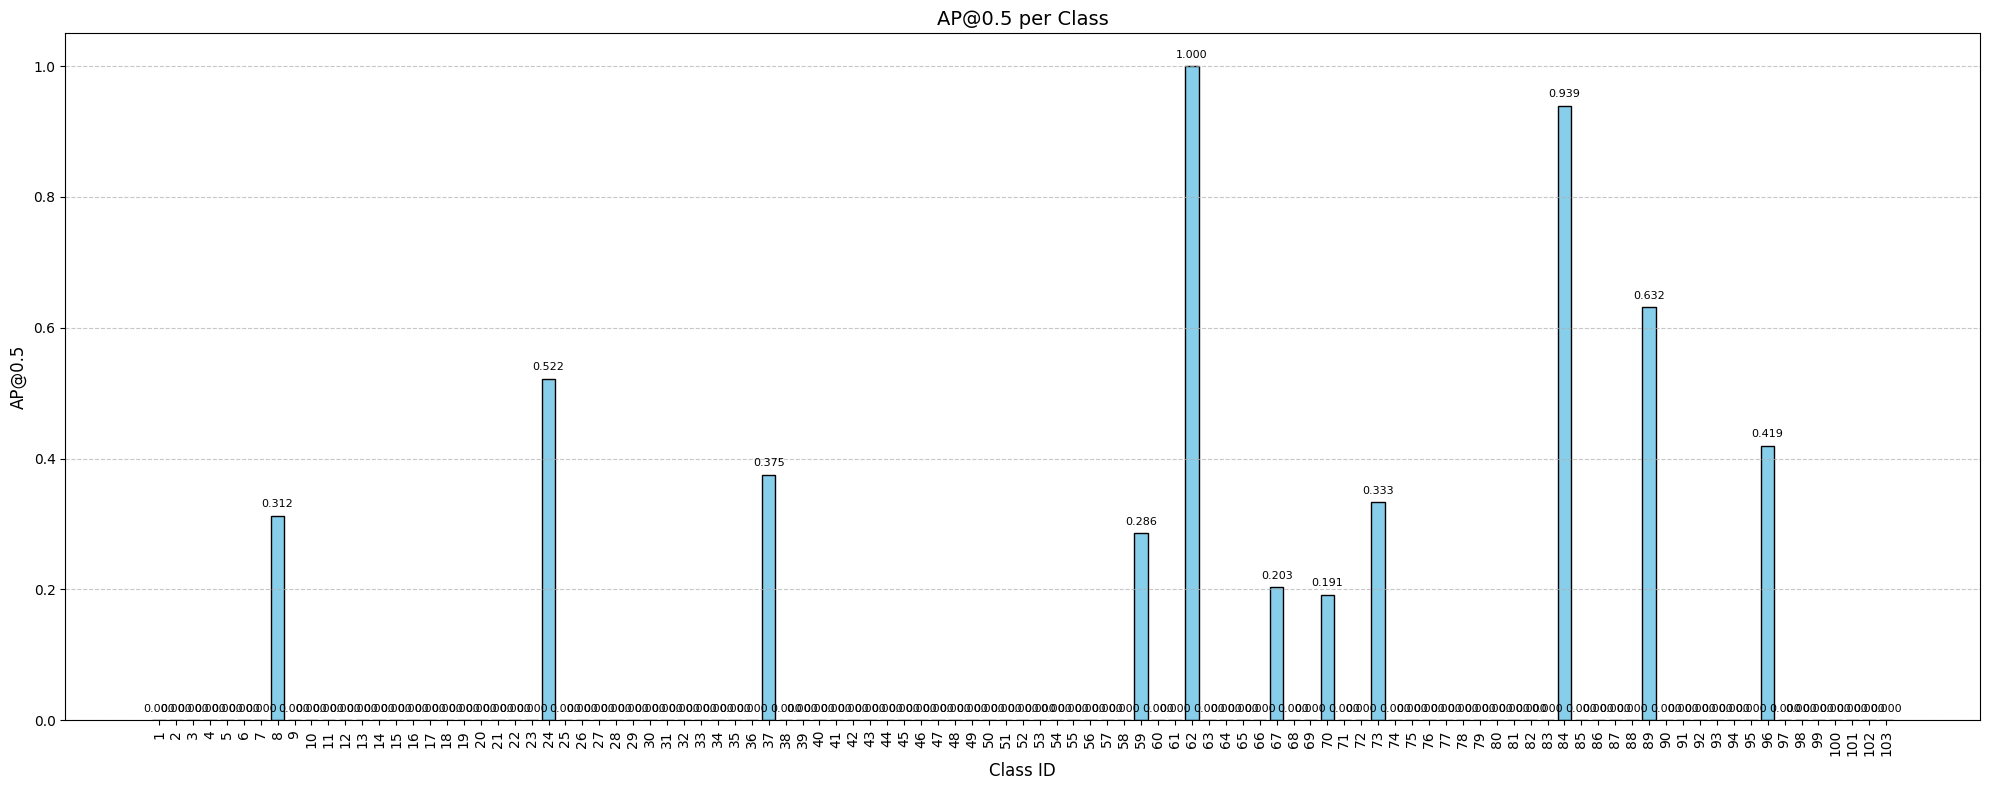

Displayed AP@0.5 plot in notebook


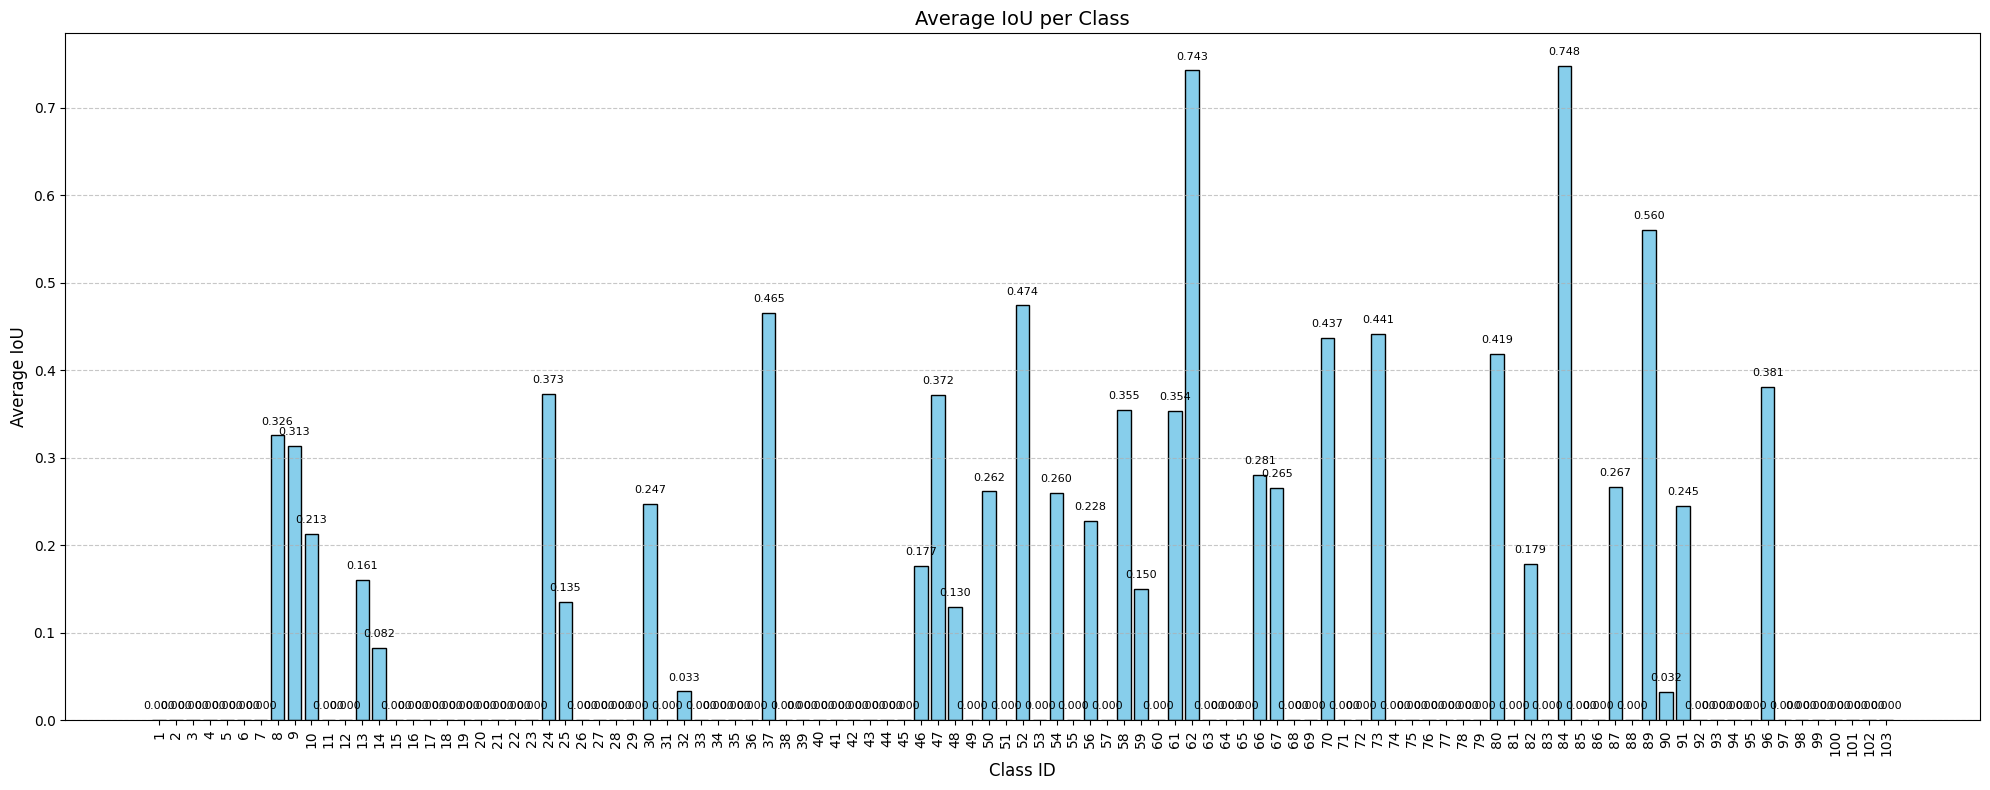

Displayed Avg_IoU plot in notebook


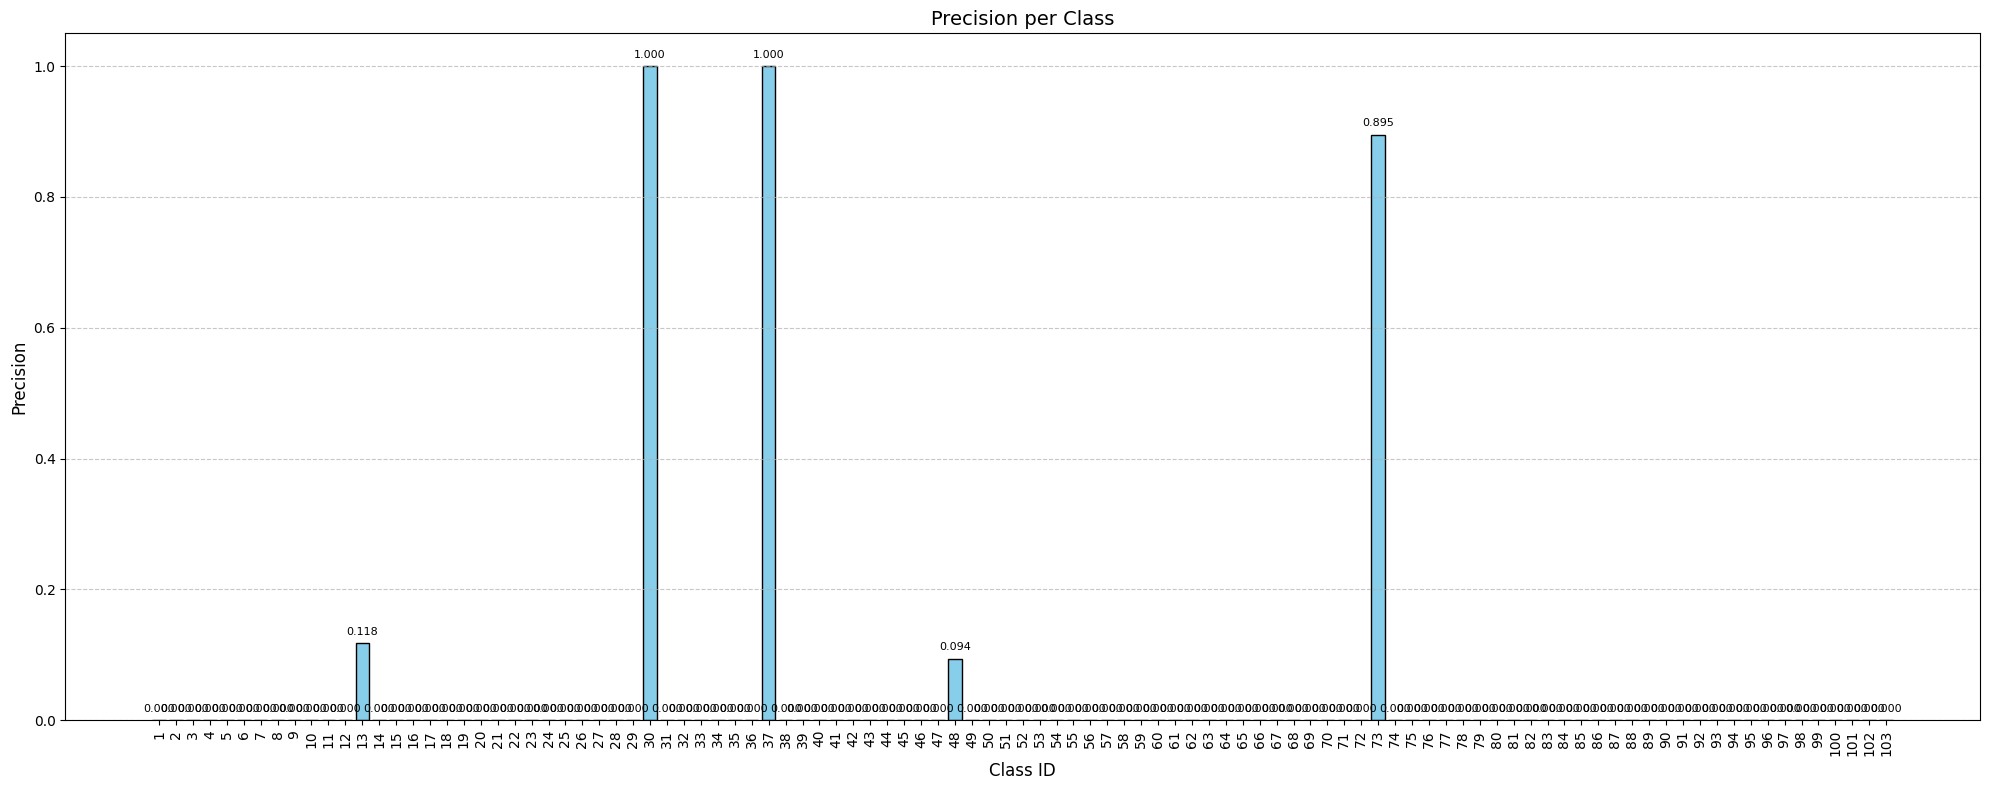

Displayed Precision plot in notebook


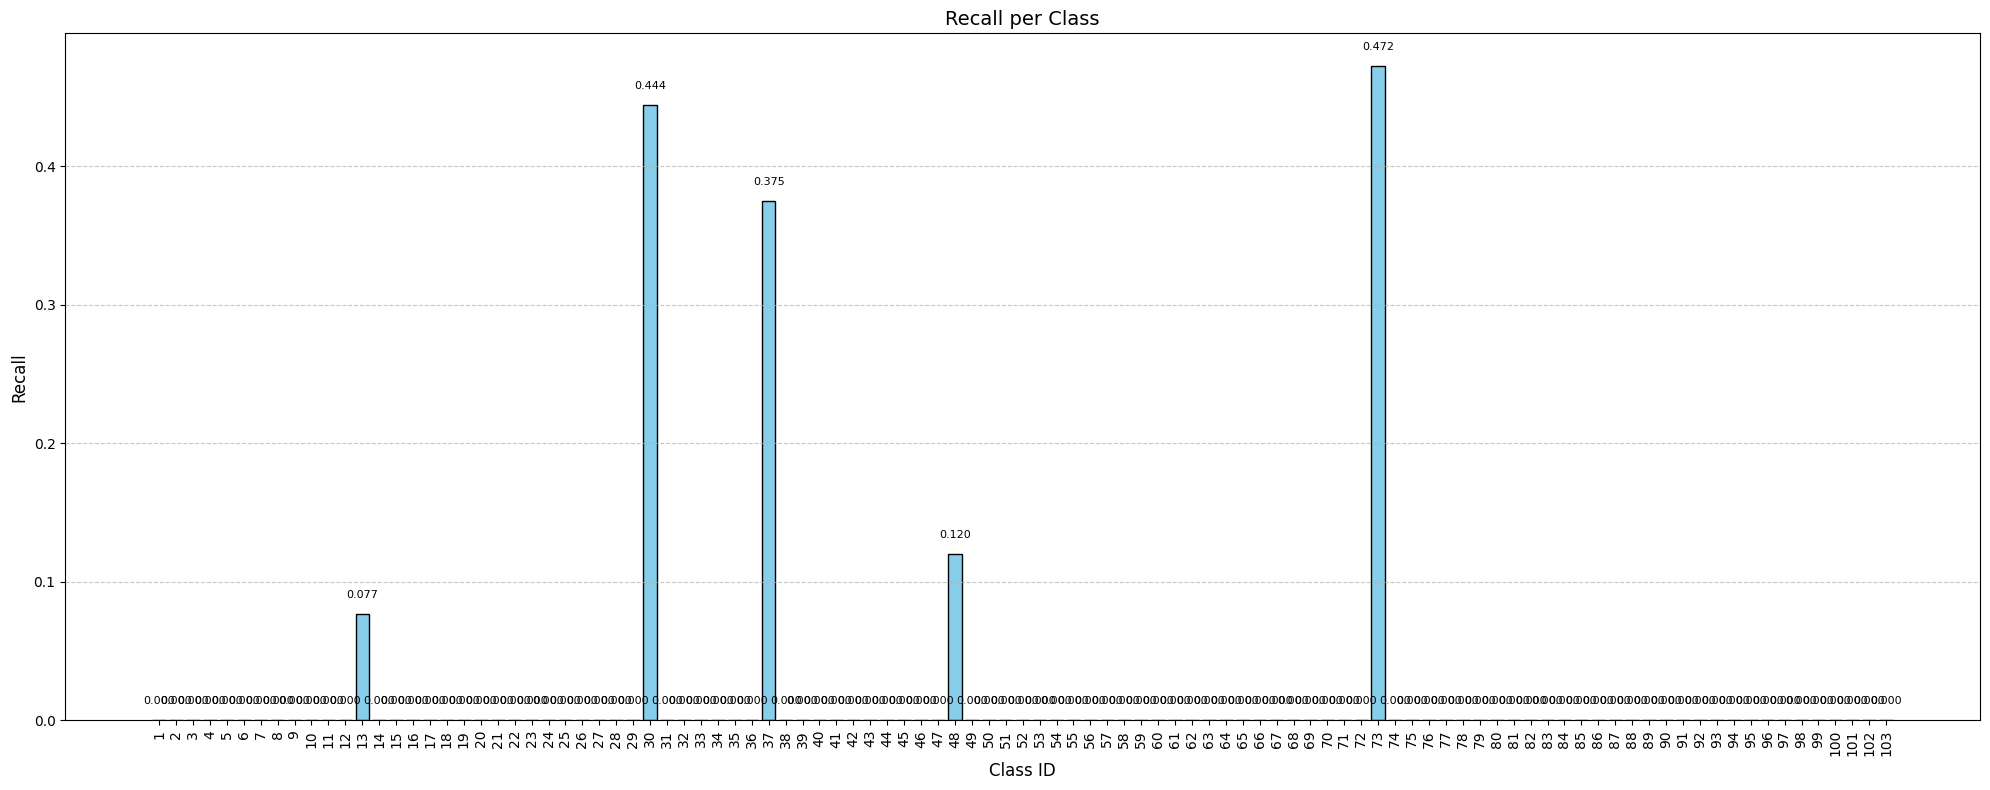

Displayed Recall plot in notebook


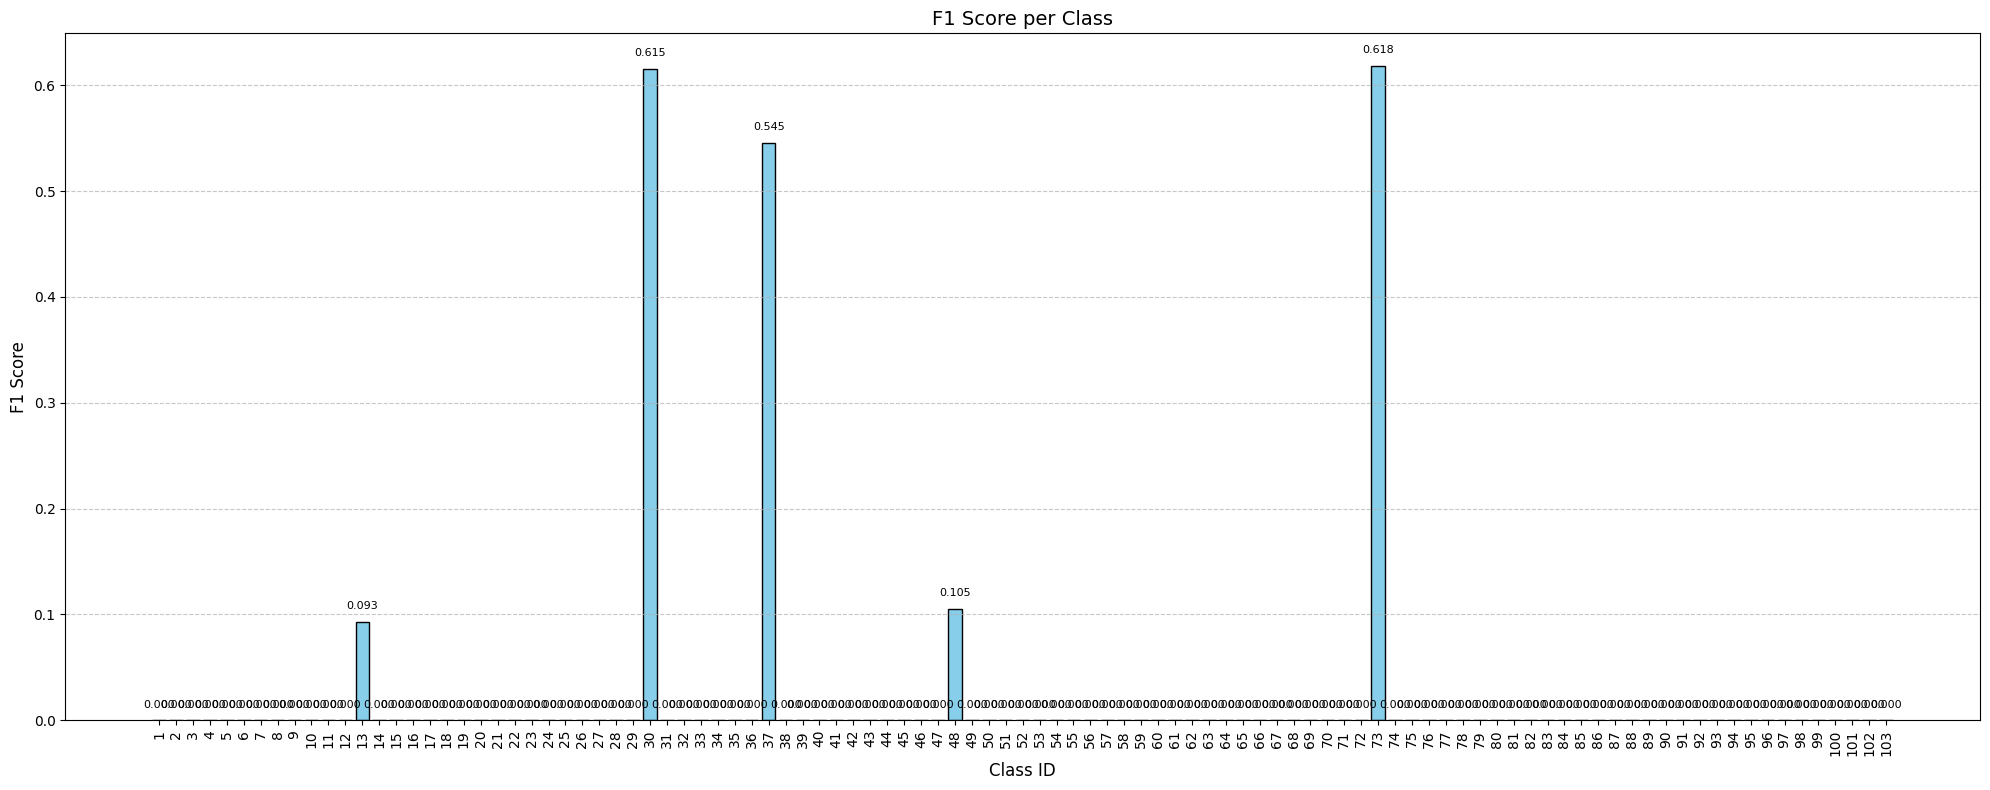

Displayed F1 plot in notebook
mAP@0.5: 0.050
Mean IoU: 0.331


In [33]:
# Run evaluation
pred_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/predictions")
gt_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/masks")
mean_ap, mean_iou = evaluate_sam(pred_dir, gt_dir, ingredients)
show_overall_performance(mean_ap, mean_iou)